In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import numpy 
import matplotlib.pyplot as plt
from tqdm import tqdm

### Device 

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

device

device(type='cuda')

### Discriminator

In [3]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__() 

        self.discriminator = nn.Sequential(
            # First block, no batch normalization 
            nn.Conv2d(
                3, 64, kernel_size = 4,
                stride = 2, padding = 1, bias = False
            ),
            nn.LeakyReLU(0.2, inplace = True), 

            # Second block
            nn.Conv2d(
                64, 128, kernel_size = 4,
                stride = 2, padding = 1, bias = False
            ),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace = True), 

            # Third block 
            nn.Conv2d(
                128, 256, kernel_size = 4,
                stride = 2, padding = 1, bias = False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace = True),

            # Fourth block
            
            nn.Conv2d(
                256, 512, kernel_size = 4,
                stride = 2, padding = 1, bias = False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace = True), 

            # Final block 
            nn.Conv2d(
                512, 1, kernel_size = 4,
                stride = 1, padding = 0, bias = False
            ),
            nn.Sigmoid(),
        )

        return 

    def forward(self, input):
        return self.discriminator(input)


### Generator

In [4]:
class Generator(nn.Module):
    def __init__(self, size_of_noise_vector):

        super(Generator, self).__init__()
        
        self.nz = size_of_noise_vector

        self.generator = nn.Sequential(
            nn.ConvTranspose2d(
                self.nz, 512, kernel_size = 4,
                stride = 1, padding = 0, bias = False,
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace = True),

            nn.ConvTranspose2d(
                512, 256, kernel_size = 4,
                stride = 2, padding = 1, bias = False,
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace = True),

            nn.ConvTranspose2d(
                256, 128, kernel_size = 4,
                stride = 2, padding = 1, bias = False,
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace = True),

            nn.ConvTranspose2d(
                128, 64, kernel_size = 4,
                stride = 2, padding = 1, bias = False,
            ),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace = True),

            # Final block 
            nn.ConvTranspose2d(
                64, 3, kernel_size = 4,
                stride = 2, padding = 1, bias = False,
            ),
            nn.Tanh()
        )

    def forward(self, input):
        return self.generator(input)

### Label Generation for images (Fake/Real)

In [5]:
def label_generation(size, is_fake = True):
    if is_fake == True:
        return torch.zeros(size, 1).to(device)
    else:
        return torch.ones(size,1).to(device)

### Noise generation for generating fake images

In [6]:
def create_noise(batch_size, nz):
    return torch.randn(batch_size, nz, 1, 1).to(device)

### Parameters initialization

In [7]:
image_size = 64 
batch_size = 200

nz         = 100
beta1      = 0.5    # Stable training for the Adam optimizer 
beta2      = 0.999  # Usual value 
lr         = 0.0002 # 0.001 was too high according to the paper
sample_size= 64 
epochs     = 100

### Load Data CIFAR - 10

In [8]:
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), 
    (0.5, 0.5, 0.5)),
])

In [9]:
train_data = datasets.OxfordIIITPet(
    root = './data',
    split = 'trainval',
    download = True, 
    transform = transform 
)

In [10]:
train_loader = DataLoader(train_data, 
                          batch_size = batch_size,
                          shuffle = True)

### Initialize GAN with Generator and Discriminator

In [11]:
generator     = Generator(nz).to(device)
discriminator = Discriminator().to(device)

In [12]:
generator_trainer = optim.Adam(generator.parameters(),
                               lr = lr,
                               betas = (beta1, beta2))

discriminator_trainer = optim.Adam(discriminator.parameters(),
                                   lr = lr,
                                   betas = (beta1, beta2))


In [13]:
criterion = nn.BCELoss()

### Setting Up Training For GAN 

In [14]:
losses_g = []
losses_d = []

In [15]:
generator.train()
discriminator.train()

Discriminator(
  (discriminator): Sequential(
    (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)

In [16]:
for epoch in range(epochs):
    loss_g , loss_d = 0.0, 0.0 
    # Discriminator training
   

    for bi, data in tqdm(enumerate(train_loader), total = int(len(train_data)/train_loader.batch_size)):
        discriminator_trainer.zero_grad()
        generator_trainer.zero_grad()

        image, _ = data 

        image  = image.to(device) 
        b_size = len(image) 

        real_label  = label_generation(b_size, is_fake = False)
        fake_label  = label_generation(b_size, is_fake = True)

        noise       = create_noise(b_size, nz) 
        fake_images = generator(noise).detach() 
        real_images = image 
        

        output_real  = discriminator(real_images).view(-1)
        output_fake  = discriminator(fake_images).view(-1)

        loss_real    = criterion(output_real.unsqueeze(1), real_label)
        loss_fake    = criterion(output_fake.unsqueeze(1), fake_label) 

        
        loss_fake.backward()
        loss_real.backward()

        discriminator_trainer.step() 

        loss_d += (loss_real.detach() + loss_fake.detach()) 

        # Generator training 
        noise       = create_noise(b_size, nz) 
        fake_images = generator(noise)

        output = discriminator(fake_images).view(-1) 
        loss   = criterion(output.unsqueeze(1), real_label) 

        loss.backward()

        generator_trainer.step()

        loss_g += (loss.detach()) 

    epoch_loss_g = loss_g / bi
    epoch_loss_d = loss_d / bi 
    
    losses_g.append(epoch_loss_g)
    losses_d.append(epoch_loss_d)
    
    print(f"Epoch {epoch+1} of {epochs}")
    print(f"Generator loss: {epoch_loss_g:.8f}, Discriminator loss: {epoch_loss_d:.8f}")


  0%|          | 0/18 [00:00<?, ?it/s]


RuntimeError: stack expects each tensor to be equal size, but got [3, 64, 90] at entry 0 and [3, 64, 96] at entry 1

In [ ]:
torch.save(generator.state_dict(), 'DCGAN_generator.pth')
torch.save(discriminator.state_dict(), 'DCGAN_discriminator.pth')

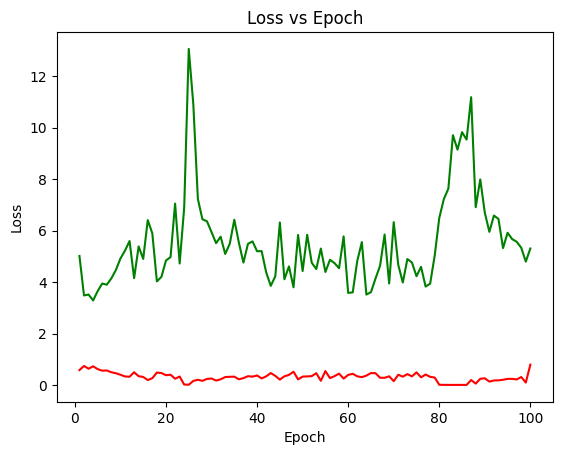

In [ ]:
for i in range(epochs):
    losses_g[i] = losses_g[i].cpu()
    losses_d[i] = losses_d[i].cpu()

plt.plot(list(range(1, epochs + 1)), losses_g, color = 'green', label = 'Generator Loss') 
plt.plot(list(range(1, epochs + 1)), losses_d, color = 'red', label = 'Discriminator Loss')

plt.title('Loss vs Epoch')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

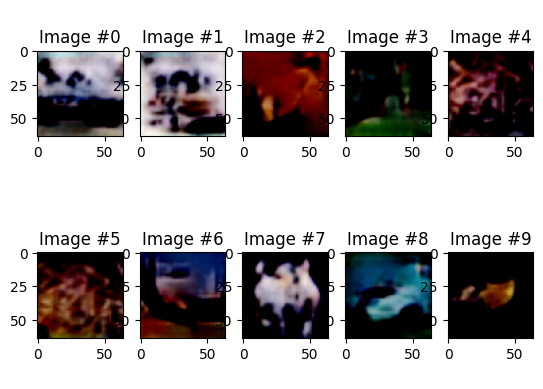

In [ ]:
noise = create_noise(10, nz)
images= generator(noise).detach()

fig = plt.figure()

plt.axis('off')
def show_image(img, i):
    plt.title('Image #' + str(i))
    plt.imshow(img.cpu().permute(1,2,0))

for i in range(len(images)):
    fig.add_subplot(2, 5, i + 1)
    show_image(images[i],i)

plt.show()

In [ ]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data

from torchvision.models.inception import inception_v3

import numpy as np
from scipy.stats import entropy

def inception_score(imgs, cuda=True, batch_size=32, resize=False, splits=1):
    """Computes the inception score of the generated images imgs

    imgs -- Torch dataset of (3xHxW) numpy images normalized in the range [-1, 1]
    cuda -- whether or not to run on GPU
    batch_size -- batch size for feeding into Inception v3
    splits -- number of splits
    """
    N = len(imgs)

    assert batch_size > 0
    assert N > batch_size

    # Set up dtype
    if cuda:
        dtype = torch.cuda.FloatTensor
    else:
        if torch.cuda.is_available():
            print("WARNING: You have a CUDA device, so you should probably set cuda=True")
        dtype = torch.FloatTensor

    # Set up dataloader
    dataloader = torch.utils.data.DataLoader(imgs, batch_size=batch_size)

    # Load inception model
    inception_model = inception_v3(pretrained=True, transform_input=False).type(dtype)
    inception_model.eval();
    up = nn.Upsample(size=(299, 299), mode='bilinear').type(dtype)
    def get_pred(x):
        if resize:
            x = up(x)
        x = inception_model(x)
        return F.softmax(x).data.cpu().numpy()

    # Get predictions
    preds = np.zeros((N, 1000))

    for i, batch in enumerate(dataloader, 0):
        batch = batch.type(dtype)
        batchv = Variable(batch)
        batch_size_i = batch.size()[0]

        preds[i*batch_size:i*batch_size + batch_size_i] = get_pred(batchv)

    # Now compute the mean kl-div
    split_scores = []

    for k in range(splits):
        part = preds[k * (N // splits): (k+1) * (N // splits), :]
        py = np.mean(part, axis=0)
        scores = []
        for i in range(part.shape[0]):
            pyx = part[i, :]
            scores.append(entropy(pyx, py))
        split_scores.append(np.exp(np.mean(scores)))

    return np.mean(split_scores), np.std(split_scores)


inception_score(images, batch_size = 1, resize = True)   

/home/aman/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/aman/.local/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipykernel_1401/3643015077.py:44: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.softmax(x).data.cpu().numpy()


(2.3093679666333786, 0.0)